In [28]:
%matplotlib inline
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset,DataLoader
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import d2lzh_pytorch.d2lzh_pytorch as d2l 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 常用的图像增广方式

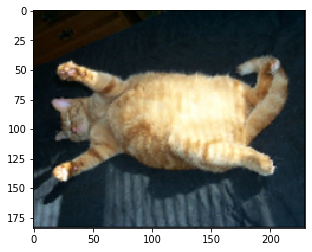

In [29]:
img = Image.open('data/cat1.jpg')
plt.imshow(img)

In [30]:
def show_images(imgs, num_rows, num_cols, scales=2):
    figsize = (num_cols * scales, num_rows * scales)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

In [31]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y =  [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

# 翻转和裁剪

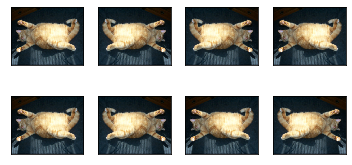

In [32]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

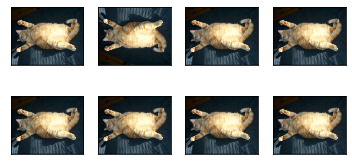

In [33]:
apply(img, torchvision.transforms.RandomVerticalFlip())

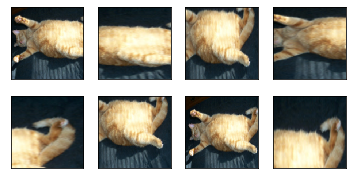

In [34]:
# 裁切
shape_aug = torchvision.transforms.RandomResizedCrop(200, scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

# 变化颜色

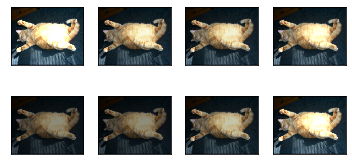

In [35]:
#亮度
apply(img, torchvision.transforms.ColorJitter(brightness=0.5))

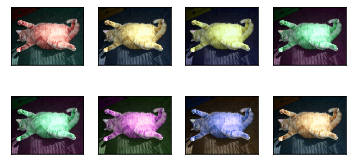

In [36]:
# 色调
apply(img, torchvision.transforms.ColorJitter(hue=0.5))

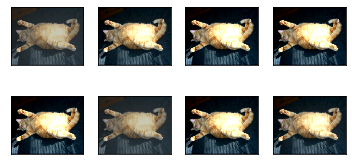

In [37]:
#对比度
apply(img, torchvision.transforms.ColorJitter(contrast=0.5))

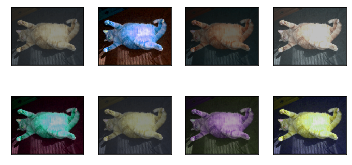

In [38]:
#同时设置
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
)

apply(img, color_aug)

# 使用图像增广训练模型


Using downloaded and verified file: ~Datasets/CIFAR/cifar-10-python.tar.gz


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1295d40f0>,
      dtype=object)

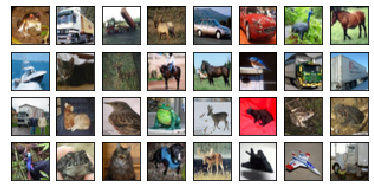

In [40]:
all_imges = torchvision.datasets.CIFAR10(train=True, root='~Datasets/CIFAR', download=True)

show_images([all_imges[i][0] for i in range(32)], 4, 8, scales=0.8)

In [41]:
flip_aug = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()
    ]
)

no_aug = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


In [42]:
num_workers = 0 if sys.platform.startswith('win32') else 4

def load_cifar10(is_train, augs, batch_size, root='~/Datasets/CIFAR'):
    dataset = torchvision.datasets.CIFAR10(root=root, train=is_train, transform=augs, download=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

# 使用图像增广训练模型

In [43]:
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)

    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = d2l.evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [ ]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    